In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [3]:
DAE_np_data_path = r'data\np\npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:
np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [5]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]

In [6]:
def prepare_experimental_data(df):
    """
    Prepare experimental data from pandas DataFrame.
    
    Args:
        df: pandas DataFrame with columns ['E_inc', 'E_sec', 'theta', 'ddcs', 'Errddcs']
    
    Returns:
        E_inc_values: tensor of unique incident energies in MeV
        experimental_ddcs: tensor of shape (n_energies, n_theta_bins)
        experimental_errors: tensor of shape (n_energies, n_theta_bins)
        valid_mask: tensor of shape (n_energies, n_theta_bins) - True where data exists
    """
    # Get unique incident energies and convert from eV to MeV
    theta_values = df['theta'].unique()
    E_inc_unique_eV = np.sort(df['E_inc'].unique())
    E_inc_unique = E_inc_unique_eV * 1e-6  # Convert eV to MeV
    n_energies = len(E_inc_unique)
    n_theta = len(theta_values)
    
    print(f"Experimental energies (eV): {E_inc_unique_eV}")
    print(f"Experimental energies (MeV): {E_inc_unique}")
    
    # Initialize arrays
    experimental_ddcs = np.full((n_energies, n_theta), np.nan)  # Use NaN instead of 0
    experimental_errors = np.full((n_energies, n_theta), np.nan)
    valid_mask = np.zeros((n_energies, n_theta), dtype=bool)
    
    # Fill the arrays
    for i, E_inc_eV in enumerate(E_inc_unique_eV):
        energy_data = df[df['E_inc'] == E_inc_eV]
        
        for j, theta in enumerate(theta_values):
            theta_data = energy_data[energy_data['theta'] == theta]
            
            if not theta_data.empty:
                # If multiple entries for same E_inc, theta, take the mean
                experimental_ddcs[i, j] = theta_data['ddcs'].mean()
                experimental_errors[i, j] = theta_data['Errddcs'].mean()
                valid_mask[i, j] = True
    
    energies_with_data = np.any(valid_mask, axis=1)
    E_inc_unique = E_inc_unique[energies_with_data]
    experimental_ddcs = experimental_ddcs[energies_with_data]
    experimental_errors = experimental_errors[energies_with_data]
    valid_mask = valid_mask[energies_with_data]
    
    # Ensure no NaN values remain
    experimental_ddcs = np.nan_to_num(experimental_ddcs, nan=1e-10, posinf=1e10, neginf=1e-10)
    experimental_errors = np.nan_to_num(experimental_errors, nan=1.0, posinf=1e10, neginf=1e-10)
    
    # Ensure positive values
    experimental_ddcs = np.maximum(experimental_ddcs, 1e-10)
    experimental_errors = np.maximum(experimental_errors, 1e-10)
    
    print(f"Final data shape: {experimental_ddcs.shape}")
    print(f"Energy range (MeV): {E_inc_unique.min():.1f} - {E_inc_unique.max():.1f}")
    print(f"DDCS range: {experimental_ddcs.min():.2e} - {experimental_ddcs.max():.2e}")
    
    return (torch.tensor(E_inc_unique, dtype=torch.float32),
            torch.tensor(experimental_ddcs, dtype=torch.float32),
            torch.tensor(experimental_errors, dtype=torch.float32),
            torch.tensor(valid_mask, dtype=torch.bool))


def integrate_ddcs_over_energy(df):
    """
    Integrates double differential cross section over outgoing proton energy (E_sec)
    to get differential cross section dσ/dΩ.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: E_inc, E_sec, theta, ddcs
        
    Returns:
    --------
    tuple: (torch.tensor, torch.tensor)
        - E_inc_unique: unique incident energies
        - experimental_ddcs: integrated cross sections with shape (n_E_inc, n_theta)
    """
    # Group by E_inc and theta, sum over E_sec
    grouped_data = df.groupby(['E_inc', 'theta'])['ddcs'].sum().reset_index()
    
    # Get unique values
    E_inc_unique = sorted(df['E_inc'].unique())
    theta_unique = sorted(df['theta'].unique())
    
    # Create a 2D array to store the results
    experimental_ddcs = np.zeros((len(E_inc_unique), len(theta_unique)))
    
    # Fill the array with the grouped data
    for _, row in grouped_data.iterrows():
        e_idx = E_inc_unique.index(row['E_inc'])
        theta_idx = theta_unique.index(row['theta'])
        experimental_ddcs[e_idx, theta_idx] = row['ddcs']
    
    # Convert to torch tensors
    return (torch.tensor(E_inc_unique, dtype=torch.float32),
            torch.tensor(experimental_ddcs, dtype=torch.float32))

In [7]:
E_inc_unique, experimental_ddcs, experimental_errors, valid_mask = prepare_experimental_data(df)

E_inc_unique, experimental_ddcs#, experimental_errors

# E_inc_unique, experimental_ddcs = integrate_ddcs_over_energy(df)

# E_inc_unique, experimental_ddcs

Experimental energies (eV): [6.5e+07 7.5e+07 8.5e+07 9.5e+07 1.1e+08 1.3e+08 1.5e+08 1.7e+08 1.9e+08
 2.1e+08 2.3e+08]
Experimental energies (MeV): [ 65.  75.  85.  95. 110. 130. 150. 170. 190. 210. 230.]
Final data shape: (11, 7)
Energy range (MeV): 65.0 - 230.0
DDCS range: 3.92e-07 - 1.29e-06


(tensor([ 65.,  75.,  85.,  95., 110., 130., 150., 170., 190., 210., 230.]),
 tensor([[8.6200e-07, 8.7965e-07, 9.2312e-07, 1.0082e-06, 9.6550e-07, 5.5022e-07,
          3.9199e-07],
         [1.0038e-06, 1.0231e-06, 1.1378e-06, 1.2055e-06, 1.1331e-06, 7.3369e-07,
          4.0359e-07],
         [1.0920e-06, 1.1233e-06, 1.2361e-06, 1.2678e-06, 1.1330e-06, 8.3293e-07,
          4.9270e-07],
         [1.0305e-06, 1.1162e-06, 1.2334e-06, 1.2856e-06, 1.1077e-06, 9.5320e-07,
          5.6919e-07],
         [9.4026e-07, 1.0092e-06, 1.1265e-06, 1.1313e-06, 9.3746e-07, 8.8322e-07,
          6.0865e-07],
         [8.7095e-07, 9.3095e-07, 1.0300e-06, 1.0043e-06, 8.6638e-07, 8.8956e-07,
          6.1718e-07],
         [7.9019e-07, 9.1226e-07, 9.9213e-07, 9.0367e-07, 8.2343e-07, 8.6037e-07,
          6.8706e-07],
         [8.2581e-07, 8.9785e-07, 9.1817e-07, 8.2226e-07, 7.8185e-07, 8.1619e-07,
          7.3736e-07],
         [7.9135e-07, 8.4800e-07, 8.3097e-07, 7.8147e-07, 7.6874e-07, 7.5674e-07,
 

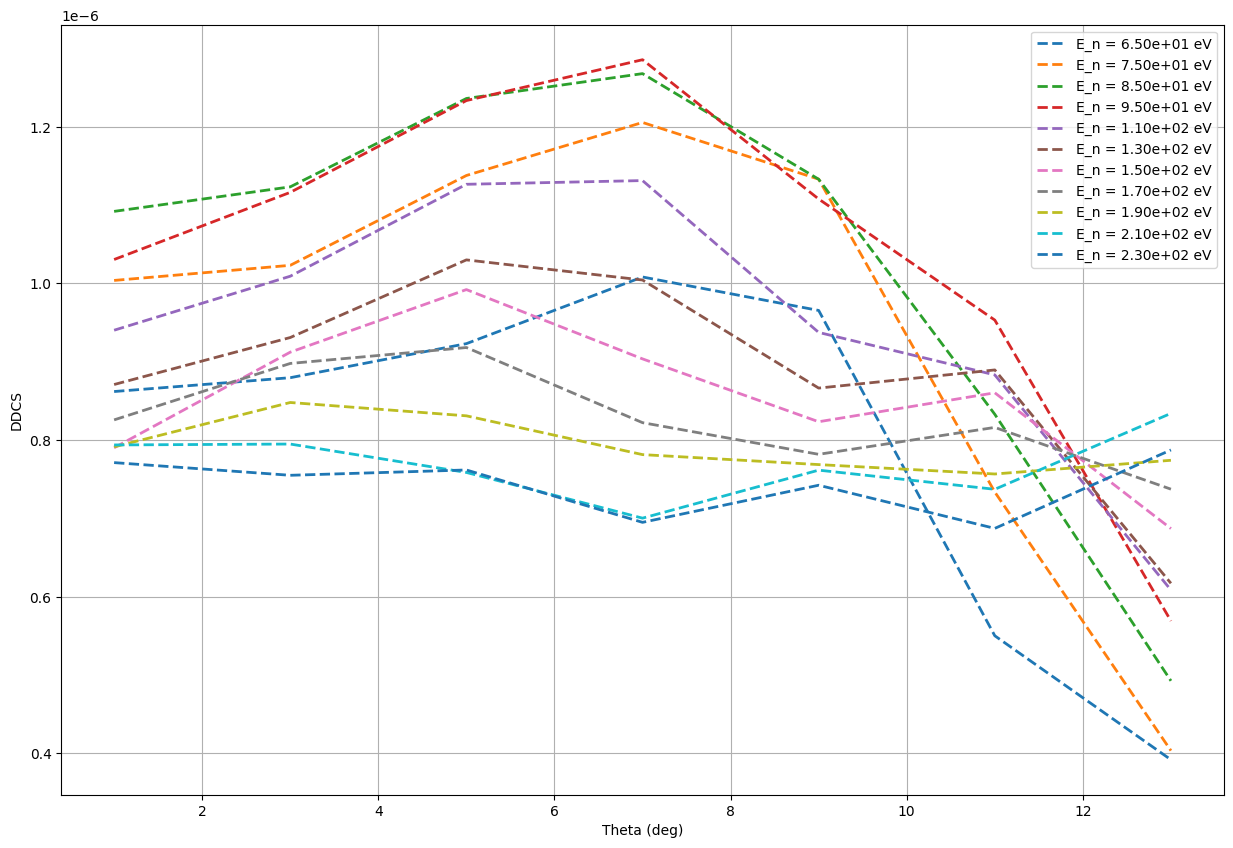

In [8]:
theta_values = df['theta'].unique()
# exp_ddcs = exp_data[1][0]
# exp_ddcs_err = exp_data[2][0]

plt.figure(figsize=(15, 10))

for i in range(len(E_inc_unique)):    
    plt.plot(theta_values, experimental_ddcs[i], '--', label=f'E_n = {E_inc_unique[i]:.2e} eV', linewidth=2)
    # plt.errorbar(theta_values, experimental_ddcs[i], yerr=experimental_errors[i], fmt='o', alpha=0.5)

plt.xlabel('Theta (deg)')
plt.ylabel('DDCS')
plt.legend()
plt.grid(True)

In [9]:
import torch
from torch import nn
import numpy as np

class NPReactionSimulator(nn.Module):
    def __init__(
        self,
        m_n=939.565,   # neutron mass [MeV/c^2]
        m_p=938.272,   # proton mass [MeV/c^2]
        M_A=29785.0,   # S-32 mass [MeV/c^2]
        S_n=7.70,      # neutron separation energy [MeV]
        S_p=13.46      # proton separation energy [MeV]
    ):
        super().__init__()
        # Store physical constants as buffers for device consistency
        self.register_buffer("m_n", torch.tensor(m_n))
        self.register_buffer("m_p", torch.tensor(m_p))
        self.register_buffer("M_A", torch.tensor(M_A))
        self.register_buffer("S_n", torch.tensor(S_n))
        self.register_buffer("S_p", torch.tensor(S_p))

    def forward(self, Ek, r1, r2, r3):
        """
        Inputs:
            Ek:  [B] neutron kinetic energy [MeV]
            r1:  [B] ∈ [0, 1] → proton energy fraction
            r2:  [B] ∈ [-1, 1] → cos(theta) direction
            r3:  [B] ∈ [-π, π] → phi direction
        Outputs:
            Ep_lab: [B] proton energy in lab frame [MeV]
            cos_theta_lab: [B] emission angle cosine in lab frame
        """
        m_n, m_p, M_A, S_n, S_p = self.m_n, self.m_p, self.M_A, self.S_n, self.S_p

        # Recoil kinetic energy
        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2 * m_n) / denom

        # Excitation energy and energy available
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0

        Ep_com = r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = r2
        sin_theta_com = torch.sqrt(torch.clamp(1 - cos_theta_com**2, min=0.0))
        phi = r3

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        v_recoil = Tk / M_recoil
        beta = v_recoil
        gamma = 1.0 / torch.sqrt(1 - beta**2 + 1e-8)

        # Lorentz boost
        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)

        # Transverse momenta unchanged
        px_lab = px_com
        py_lab = py_com
        p_mag_lab = torch.sqrt(px_lab**2 + py_lab**2 + pz_lab**2 + 1e-8)

        Ep_lab = E_lab - m_p
        cos_theta_lab = pz_lab / (p_mag_lab + 1e-8)

        # Apply reaction validity mask
        Ep_lab = torch.where(mask, Ep_lab, torch.zeros_like(Ep_lab))
        cos_theta_lab = torch.where(mask, cos_theta_lab, torch.zeros_like(cos_theta_lab))

        return Ep_lab, cos_theta_lab


In [10]:
import torch
import torch.nn as nn
import math

class DifferentiableDDCSEstimator(nn.Module):
    def __init__(self,
                 E_grid: torch.Tensor,
                 costh_grid: torch.Tensor,
                 bw_E: float = 0.5,
                 bw_cos: float = 0.05,
                 normalize: bool = True):
        """
        Differentiable KDE-based estimator of double differential cross section (DDCS).

        Args:
            E_grid:      [N_E] 1D tensor of proton energy grid centers (MeV)
            costh_grid:  [N_cos] 1D tensor of cos(theta) grid centers
            bw_E:        Bandwidth for energy dimension (MeV)
            bw_cos:      Bandwidth for cos(theta) dimension
            normalize:   Normalize DDCS to area 1 if True
        """
        super().__init__()
        self.register_buffer("E_grid", E_grid)
        self.register_buffer("costh_grid", costh_grid)
        self.bw_E = bw_E
        self.bw_cos = bw_cos
        self.normalize = normalize

    def forward(self, Ep_lab: torch.Tensor, cos_theta_lab: torch.Tensor) -> torch.Tensor:
        """
        Compute differentiable double differential cross section (DDCS).

        Args:
            Ep_lab:         [B] Proton kinetic energies
            cos_theta_lab:  [B] Cosines of emission angles

        Returns:
            ddcs_pdf:       [N_E, N_costh] DDCS estimate (optionally normalized)
        """
        assert Ep_lab.ndim == 1 and cos_theta_lab.ndim == 1
        assert Ep_lab.shape == cos_theta_lab.shape

        B = Ep_lab.shape[0]
        E_grid, costh_grid = self.E_grid, self.costh_grid

        # 2D grid
        E_centers, costh_centers = torch.meshgrid(E_grid, costh_grid, indexing='ij')  # [N_E, N_costh]

        # Expand inputs for broadcasting
        Ep_lab = Ep_lab[:, None, None]             # [B, 1, 1]
        cos_theta_lab = cos_theta_lab[:, None, None]

        # Compute soft distances
        dE = Ep_lab - E_centers[None, :, :]
        dcos = cos_theta_lab - costh_centers[None, :, :]

        # 2D Gaussian kernel
        exponent = -0.5 * ((dE / self.bw_E)**2 + (dcos / self.bw_cos)**2)
        kernel = torch.exp(exponent) / (2 * math.pi * self.bw_E * self.bw_cos)  # [B, N_E, N_costh]

        # Aggregate samples
        ddcs_pdf = kernel.sum(dim=0) / B  # [N_E, N_costh]

        if self.normalize:
            dE_bin = E_grid[1] - E_grid[0]
            dcos_bin = costh_grid[1] - costh_grid[0]
            area = ddcs_pdf.sum() * dE_bin * dcos_bin + 1e-12
            ddcs_pdf = ddcs_pdf / area

        return ddcs_pdf  # [N_E, N_costh]


class NormalizedDDCSEstimator(nn.Module):
    def __init__(self, E_grid, costh_grid, sigma_E=0.2, sigma_cos=0.02):
        super().__init__()
        self.register_buffer("E_grid", E_grid)
        self.register_buffer("costh_grid", costh_grid)
        self.sigma_E = sigma_E
        self.sigma_cos = sigma_cos

        # Precompute bin widths
        self.register_buffer("dE_eV", torch.diff(E_grid) * 1e6)  # [E-1] → eV
        dcos = torch.diff(costh_grid)
        self.register_buffer("dOmega", 2 * np.pi * dcos)  # [C-1] steradian widths

    def forward(self, Ep_lab, cos_theta_lab):
        B = Ep_lab.shape[0]
        E_centers = 0.5 * (self.E_grid[:-1] + self.E_grid[1:])  # [E-1]
        cos_centers = 0.5 * (self.costh_grid[:-1] + self.costh_grid[1:])  # [C-1]

        Ep = Ep_lab[:, None]  # [B, 1]
        cos_theta = cos_theta_lab[:, None]  # [B, 1]

        # Smoothing kernels
        E_weights = torch.exp(-0.5 * ((Ep - E_centers) / self.sigma_E) ** 2)  # [B, E-1]
        costh_weights = torch.exp(-0.5 * ((cos_theta - cos_centers) / self.sigma_cos) ** 2)  # [B, C-1]

        weights = costh_weights[:, :, None] * E_weights[:, None, :]  # [B, C-1, E-1]
        counts = weights.sum(dim=0)  # [C-1, E-1]

        # Normalize by number of samples and bin widths
        dE = self.dE_eV[None, :]       # [1, E-1]
        dO = self.dOmega[:, None]      # [C-1, 1]

        norm_ddcs = counts / (B * dE * dO + 1e-12)  # [C-1, E-1]
        return norm_ddcs



In [11]:
class DDCSPipeline(nn.Module):
    def __init__(self, E_grid, costh_grid, sigma_E=0.2, sigma_cos=0.02):
        super().__init__()
        self.simulator = NPReactionSimulator()
        # self.ddcs_estimator = DifferentiableDDCSEstimator(
        #     E_grid, costh_grid, sigma_E=sigma_E, sigma_cos=sigma_cos
        # )
        self.ddcs_estimator = NormalizedDDCSEstimator(E_grid, costh_grid, sigma_E, sigma_cos)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        DDCS = self.ddcs_estimator(Ep_lab, cos_theta_lab)
        return DDCS  # shape: [costh_bins, E_bins]


In [12]:
def suggest_energy_grid(Ep_lab, num_bins=100, padding=0.1):
    """
    Suggests an energy grid based on simulated proton energies.

    Args:
        Ep_lab:    [B] simulated proton energies [MeV] (Tensor)
        num_bins:  number of energy bins in the grid
        padding:   relative padding to apply on min/max (e.g., 0.1 → ±10%)

    Returns:
        E_grid:    [num_bins] Tensor of energy bin centers
    """
    Ep_flat = Ep_lab.detach().flatten()
    Ep_min = Ep_flat.min()
    Ep_max = Ep_flat.max()

    # Add padding on both sides
    E_range = Ep_max - Ep_min
    E_low = Ep_min - padding * E_range
    E_high = Ep_max + padding * E_range

    # Ensure limits are non-negative
    E_low = torch.clamp(E_low, min=0.0)

    E_grid = torch.linspace(E_low, E_high, num_bins, device=Ep_lab.device)
    return E_grid


def setup_ddcs_simulation(Ep_lab, num_E_bins=100, num_angle_bins=180, theta_min_deg=1.0, theta_max_deg=13.0):
    E_grid = suggest_energy_grid(Ep_lab, num_bins=num_E_bins, padding=0.05)

    # Convert angular range to cos(theta)
    theta_min_rad = torch.tensor(np.radians(theta_min_deg))
    theta_max_rad = torch.tensor(np.radians(theta_max_deg))

    costh_min = torch.cos(theta_max_rad)
    costh_max = torch.cos(theta_min_rad)

    costh_grid = torch.linspace(costh_min, costh_max, num_angle_bins)

    return E_grid, costh_grid



In [32]:
import torch
import numpy as np

# Sample parameters
B = 2000
Ek = torch.full((B,), 65.0)
uniform_samples = torch.rand((batch_size, n_in), device=device)  # uniform [0,1)

r1 = uniform_samples[:, 0]                            # stays in [0, 1)
r2 = uniform_samples[:, 1] * 2 - 1                    # maps [0,1) -> [-1, 1)
r3 = uniform_samples[:, 2] * 2 * torch.pi - torch.pi  # maps [0,1) -> [-π, π)

# First simulate once to get energy range
Ep_lab, _ = NPReactionSimulator()(Ek, r1, r2, r3)
E_grid, costh_grid = setup_ddcs_simulation(Ep_lab, num_E_bins=100, num_angle_bins=180, theta_min_deg=1, theta_max_deg=13)

# Create full pipeline
pipeline = DDCSPipeline(E_grid, costh_grid)

# Run
ddcs = pipeline(Ek, r1, r2, r3)  * (0.005) # shape: [costh_bins, E_bins]


In [33]:
ddcs.size()

torch.Size([179, 99])

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ddcs_vs_angle(ddcs, E_grid, costh_grid, E_slice: float = None, avg_width: float = 0.5):
    """
    Plot DDCS vs angle for a given energy slice (averaged over a small window).

    Args:
        ddcs:       [N_costh, N_E] DDCS array from estimator (angles x energies)
        E_grid:     [N_E+1] energy bin edges (torch Tensor)
        costh_grid: [N_costh+1] cos(theta) bin edges (torch Tensor)
        E_slice:    energy [MeV] to slice at (center)
        avg_width:  width of energy window to average over [MeV]
    """
    ddcs_np = ddcs.detach().cpu().numpy()
    E_edges_np = E_grid.detach().cpu().numpy()
    costh_edges_np = costh_grid.detach().cpu().numpy()

    # Bin centers
    E_centers = 0.5 * (E_edges_np[:-1] + E_edges_np[1:])     # [N_E]
    costh_centers = 0.5 * (costh_edges_np[:-1] + costh_edges_np[1:])  # [N_costh]
    theta_deg = np.degrees(np.arccos(np.clip(costh_centers, -1.0, 1.0)))

    if E_slice is not None:
        # Select energy bins within the averaging window
        E_mask = (E_centers >= E_slice - avg_width / 2) & (E_centers <= E_slice + avg_width / 2)
        if not np.any(E_mask):
            raise ValueError(f"No bins found near E_slice = {E_slice:.2f} MeV")
        ddcs_angle = ddcs_np[:, E_mask].mean(axis=1)  # [N_costh]
        label = rf"{E_slice:.2f} MeV $\pm$ {avg_width/2:.2f}"
        ylabel = r"$\frac{d^2\sigma}{dE_p\, d\Omega}$ [1 / (eV·sr)]"
    else:
        # Integrate (average) over all energy bins
        E_widths = E_edges_np[1:] - E_edges_np[:-1]   # shape: [N_E]
        ddcs_angle = np.sum(ddcs_np * E_widths[None, :], axis=1)  # Weighted sum over E

        # ddcs_angle = ddcs_np.mean(axis=1)
        label = "Integrated over all $E_p$"
        ylabel = r"$\frac{d\sigma}{d\Omega}$ [1 / (eV·sr)]"


    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(theta_deg, ddcs_angle, label=label)
    plt.xlabel(r"Proton Emission Angle $\theta$ [deg]")
    # plt.ylabel(r"$\frac{d^2\sigma}{dE_p\, d\Omega}$ [1 / (eV·sr)]")
    plt.ylabel(ylabel)
    plt.title("Double Differential Cross Section vs Angle")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


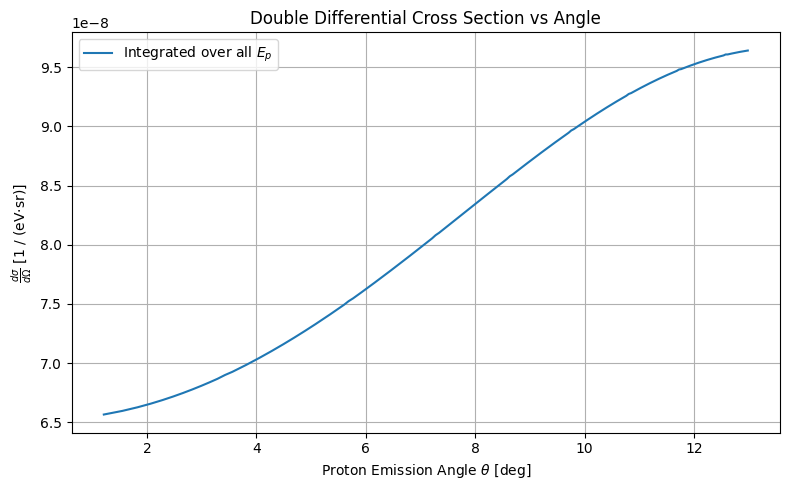

In [35]:
# plot_ddcs_vs_angle(ddcs, E_grid, costh_grid, E_slice=5.0, avg_width=0.3)

# # Integrated over all Ep
plot_ddcs_vs_angle(ddcs, E_grid, costh_grid)


In [14]:
import torch
import torch.nn.functional as F

def kl_ddcs_loss(simulated_ddcs, experimental_ddcs, eps=1e-12):
    """
    Compute KL divergence between simulated and experimental DDCS data.
    Works for 1D (single sample) or 2D (batch x features) tensors.

    Args:
        simulated_ddcs: tensor [..., features]
        experimental_ddcs: tensor [..., features]

    Returns:
        scalar KL divergence loss
    """
    # Normalize over last dimension
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    # Clamp to avoid log(0)
    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    # KL divergence
    kl = (exp_dist * (exp_dist.log() - sim_dist.log())).sum(dim=-1)

    return kl.mean()



In [15]:
def get_bin_centers(grid):
    return 0.5 * (grid[:-1] + grid[1:])


def extract_simulated_dsigma_domega(ddcs_simulated, E_grid, costh_grid, theta_exp_deg):
    """
    Extract simulated dσ/dΩ by summing over E and matching cos(theta) bins to experimental theta.

    ddcs_simulated: [C-1, E-1] tensor (simulated DDCS at bin centers)
    E_grid: edges tensor, length E
    costh_grid: edges tensor, length C
    theta_exp_deg: list of experimental theta in degrees

    Returns:
        ddcs_matched: tensor [len(theta_exp_deg)] matching simulation at bin centers closest to experimental angles
    """
    costh_centers = get_bin_centers(costh_grid)  # length C-1
    E_centers = get_bin_centers(E_grid)          # length E-1

    # Sum ddcs over proton energy dimension with bin widths to get dσ/dΩ vs angle
    dE = torch.diff(E_grid)
    ddcs_angle = (ddcs_simulated * dE[None, :]).sum(dim=1)  # shape: [C-1]

    # Convert experimental theta to cos(theta)
    theta_exp_rad = torch.tensor(np.radians(theta_exp_deg), device=ddcs_simulated.device)
    costh_exp = torch.cos(theta_exp_rad)

    # For each experimental cos(theta), find closest bin center index
    idxs = torch.argmin(torch.abs(costh_centers[:, None] - costh_exp[None, :]), dim=0)  # shape: len(theta_exp_deg)

    ddcs_matched = ddcs_angle[idxs]

    return ddcs_matched



In [16]:
# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
n_hidden    = 12      # number of hidden neurons in the network, at each layer
n_layers    = 3       # number of hidden layers in the network
n_out       = n_in    # must match the number of output parameters
batch_size  = 2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
epochs      = 2   # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer

# ------------------------------------------------------------------
# MLP producing seeds in [0,1]^7
# ------------------------------------------------------------------
def make_mlp(n_in, n_hidden, n_layers, n_out):
    layers, d = [], n_in
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden), nn.ReLU()]
        d = n_hidden
    layers += [nn.Linear(d, n_out), nn.Sigmoid()]
    return nn.Sequential(*layers)

net       = make_mlp(n_in, n_hidden, n_layers, n_out).to(device)
optimiser = optim.Adam(net.parameters(), lr=lr)
# log_scale = torch.nn.Parameter(torch.tensor(-13.8155, device=device))
# optimiser = optim.Adam(list(net.parameters()) + [log_scale], lr=lr) 

# barn_scale = torch.nn.Parameter(torch.tensor(0.005, device=device))
# optimiser = optim.Adam(list(net.parameters()) + [barn_scale], lr=lr) 


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



net.train()
for epoch in trange(epochs, desc="Training Epochs"):

    for i in range(len(E_inc_unique)):
        # Prepare neutron energy for this batch
        Ek_val = E_inc_unique[i]  # scalar
        Ek = torch.full((batch_size,), Ek_val, dtype=torch.float32).to(device)

        # Sample random inputs and feed to ML
        uniform_samples = torch.rand((batch_size, n_in), device=device)  # uniform [0,1)
        
        #WITH NET --> simulation outputs only zeros...
        t = net(uniform_samples)  # Output shape: [batch_size, 3]
        r1 = t[:, 0]                            # in [0,1]
        # A trick to match to the exp data!
        # Basically since we are limited to 1,..., 13 deg we cannot generate cos(theta) values outside of this range.
        # If we did (so keep r2 = t[:, 1] * 2 - 1 ) we would generate mostly values outside of the histogram and it would cause everything to zero out!
        cos_min = torch.cos(torch.deg2rad(torch.tensor(13.0))).item()  
        cos_max = torch.cos(torch.deg2rad(torch.tensor(1.0))).item()   
        r2 = t[:, 1] * (cos_max - cos_min) + cos_min
        # r2 = t[:, 1] * 2 - 1                    # map [0,1] -> [-1,1]
        r3 = t[:, 2] * 2 * torch.pi - torch.pi  # map [0,1] -> [-π, π]

        print(r1,r2,r3)
        # Setup bins (E_p and theta) for DDCS determination
        # These are "good guesses", basically we simulate once to get appropriate values that we can later use to build the bins 
        Ep_lab, cos_theta_lab = NPReactionSimulator()(Ek, r1, r2, r3)
        print(Ep_lab, cos_theta_lab)
        E_grid, costh_grid = setup_ddcs_simulation(Ep_lab, num_E_bins=100, num_angle_bins=180, theta_min_deg=1, theta_max_deg=13)

        # Run differentiable reaction simulation -> Compute simulated DDCS
        pipeline = DDCSPipeline(E_grid, costh_grid)
        ddcs_pred = pipeline(Ek, r1, r2, r3) # shape: [costh_bins, E_bins]

        # print(ddcs_pred)

        ddcs_target = experimental_ddcs[i].to(device)

        delta_E = E_grid[1] - E_grid[0]
        ddcs_angle_only = ddcs_pred.sum(dim=1) * delta_E  # Still shape: [N_costh_bins]
        ddcs_pred_matched = extract_simulated_dsigma_domega(
            ddcs_pred, E_grid, costh_grid,
            theta_exp_deg=[1,3,5,7,9,11,13]
        )
        # print(ddcs_pred_matched)

        # scale = barn_scale #torch.exp(log_scale)
        # scaled_simulated_ddcs = ddcs_pred_matched * scale
        # loss = kl_ddcs_loss(scaled_simulated_ddcs, ddcs_target)

        loss = kl_ddcs_loss(ddcs_pred_matched, ddcs_target)

        # Backprop
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # total_loss += loss.item()

    print(f"Epoch {epoch+1:3d} | Loss: {loss:.6f}")
    # print(f"Epoch {epoch + 1} | Loss: {loss.item():.4f} | Scale: {scale.item():.2e}")


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

tensor([0.5552, 0.5428, 0.5577,  ..., 0.5454, 0.5531, 0.5470],
       grad_fn=<SelectBackward0>) tensor([0.9868, 0.9865, 0.9869,  ..., 0.9865, 0.9868, 0.9865],
       grad_fn=<AddBackward0>) tensor([-0.2538, -0.2415, -0.2678,  ..., -0.2351, -0.2668, -0.2090],
       grad_fn=<SubBackward0>)
tensor([32.8891, 32.1528, 33.0381,  ..., 32.3051, 32.7639, 32.3993],
       grad_fn=<WhereBackward0>) tensor([0.9868, 0.9865, 0.9869,  ..., 0.9865, 0.9868, 0.9865],
       grad_fn=<WhereBackward0>)
tensor([0.5479, 0.5474, 0.5515,  ..., 0.5573, 0.5477, 0.5426],
       grad_fn=<SelectBackward0>) tensor([0.9867, 0.9866, 0.9867,  ..., 0.9869, 0.9867, 0.9865],
       grad_fn=<AddBackward0>) tensor([-0.2698, -0.2177, -0.2235,  ..., -0.2601, -0.2441, -0.2249],
       grad_fn=<SubBackward0>)
tensor([37.9333, 37.9012, 38.1851,  ..., 38.5854, 37.9206, 37.5664],
       grad_fn=<WhereBackward0>) tensor([0.9867, 0.9866, 0.9867,  ..., 0.9869, 0.9867, 0.9865],
       grad_fn=<WhereBackward0>)
tensor([0.5507, 0.5411

Training Epochs:  50%|█████     | 1/2 [00:01<00:01,  1.58s/it]

Epoch   1 | Loss: 0.006935
tensor([0.5566, 0.5464, 0.5496,  ..., 0.5450, 0.5570, 0.5492],
       grad_fn=<SelectBackward0>) tensor([0.9875, 0.9871, 0.9872,  ..., 0.9870, 0.9875, 0.9873],
       grad_fn=<AddBackward0>) tensor([-0.2967, -0.2732, -0.2669,  ..., -0.2438, -0.2860, -0.2809],
       grad_fn=<SubBackward0>)
tensor([32.9688, 32.3687, 32.5572,  ..., 32.2860, 32.9919, 32.5337],
       grad_fn=<WhereBackward0>) tensor([0.9875, 0.9871, 0.9872,  ..., 0.9870, 0.9875, 0.9873],
       grad_fn=<WhereBackward0>)
tensor([0.5455, 0.5506, 0.5561,  ..., 0.5462, 0.5590, 0.5468],
       grad_fn=<SelectBackward0>) tensor([0.9870, 0.9873, 0.9874,  ..., 0.9870, 0.9876, 0.9872],
       grad_fn=<AddBackward0>) tensor([-0.2493, -0.2756, -0.2772,  ..., -0.2308, -0.2942, -0.2651],
       grad_fn=<SubBackward0>)
tensor([37.7690, 38.1201, 38.4980,  ..., 37.8162, 38.7028, 37.8607],
       grad_fn=<WhereBackward0>) tensor([0.9870, 0.9873, 0.9874,  ..., 0.9870, 0.9876, 0.9872],
       grad_fn=<WhereBackwar

Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

tensor([0.5455, 0.5683, 0.5562,  ..., 0.5721, 0.5568, 0.5458],
       grad_fn=<SelectBackward0>) tensor([0.9875, 0.9884, 0.9880,  ..., 0.9885, 0.9880, 0.9874],
       grad_fn=<AddBackward0>) tensor([-0.2649, -0.3210, -0.3041,  ..., -0.3208, -0.2948, -0.2333],
       grad_fn=<SubBackward0>)
tensor([122.2865, 127.4044, 124.6901,  ..., 128.2612, 124.8180, 122.3687],
       grad_fn=<WhereBackward0>) tensor([0.9875, 0.9884, 0.9880,  ..., 0.9885, 0.9880, 0.9874],
       grad_fn=<WhereBackward0>)
Epoch   2 | Loss: 0.006861


In [18]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def evaluate_model_against_ddcs(
    net,
    ddcs_pipeline,           # Should be a callable: (Ek, r1, r2, r3) → [C, E]
    E_inc_unique,            # List or tensor of incident neutron energies
    experimental_ddcs,       # List of [num_angles,] tensors
    theta_exp_deg,           # List of angles at which experiments are measured
    batch_size=2000,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    net.eval()
    kl_total = 0.0
    all_stats = []

    with torch.no_grad():
        for i, Ek_val in enumerate(E_inc_unique):
            Ek = torch.full((batch_size,), Ek_val, dtype=torch.float32).to(device)

            # Sample uniform inputs and feed to net
            uniform_samples = torch.rand((batch_size, 3), device=device)
            t = net(uniform_samples)
            r1 = t[:, 0]                            # [0, 1]
            
            # Project into correct physical ranges
            cos_min = torch.cos(torch.deg2rad(torch.tensor(13.0))).item()
            cos_max = torch.cos(torch.deg2rad(torch.tensor(1.0))).item()
            r2 = t[:, 1] * (cos_max - cos_min) + cos_min  # cos(theta) in correct range
            r3 = t[:, 2] * 2 * torch.pi - torch.pi         # [-π, π]

            # Run the pipeline and extract predicted DDCS
            Ep_lab, _ = NPReactionSimulator()(Ek, r1, r2, r3)
            E_grid, costh_grid = setup_ddcs_simulation(Ep_lab, num_E_bins=100, num_angle_bins=180, theta_min_deg=1, theta_max_deg=13)
            ddcs_pred_full = DDCSPipeline(E_grid, costh_grid)(Ek, r1, r2, r3)

            # Collapse over E to match experimental format
            delta_E = E_grid[1] - E_grid[0]
            ddcs_angle_only = ddcs_pred_full.sum(dim=1) * delta_E  # [N_costh_bins]

            ddcs_pred_matched = extract_simulated_dsigma_domega(
                ddcs_pred_full, E_grid, costh_grid, theta_exp_deg=theta_exp_deg
            )
            ddcs_exp = experimental_ddcs[i].to(device)

            # Normalize
            sim_norm = ddcs_pred_matched / (ddcs_pred_matched.sum() + 1e-12)
            exp_norm = ddcs_exp / (ddcs_exp.sum() + 1e-12)

            # KL divergence (scalar)
            kl_div = F.kl_div(torch.log(sim_norm + 1e-12), exp_norm, reduction='batchmean')
            kl_total += kl_div.item()
            all_stats.append(kl_div.item())

            # scale = torch.exp(log_scale).item()
            # scale = barn_scale.item()

            # Plot
            plt.figure(figsize=(6, 4))
            # plt.plot(theta_exp_deg, ddcs_exp.cpu(), 'ro-', label='Experiment')
            plt.plot(theta_exp_deg, ddcs_pred_matched.cpu(), 'b^-', label='Simulated')
            # plt.plot(theta_exp_deg, (ddcs_pred_matched * scale).cpu(), 'b^-', label=f'Simulated x {scale:.2e}')
            plt.title(f"DDCS Comparison at E_inc = {Ek_val:.1f} MeV")
            plt.xlabel("Scattering Angle (deg)")
            plt.ylabel("d²σ/dΩdE (arb. units)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Summary stats
    print("\nEvaluation Summary:")
    for i, Ek_val in enumerate(E_inc_unique):
        print(f" - E_inc = {Ek_val:.1f} MeV | KL divergence = {all_stats[i]:.6f}")
    print(f"\nAverage KL Divergence: {kl_total / len(E_inc_unique):.6f}")


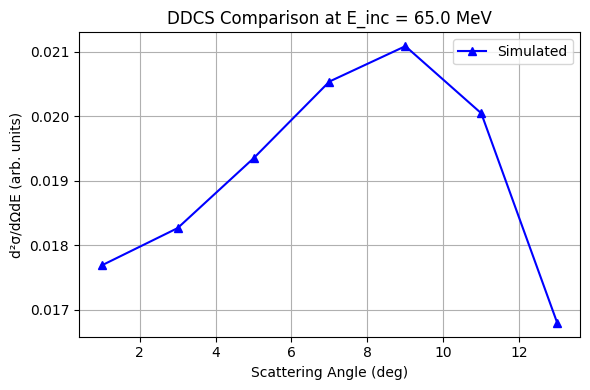

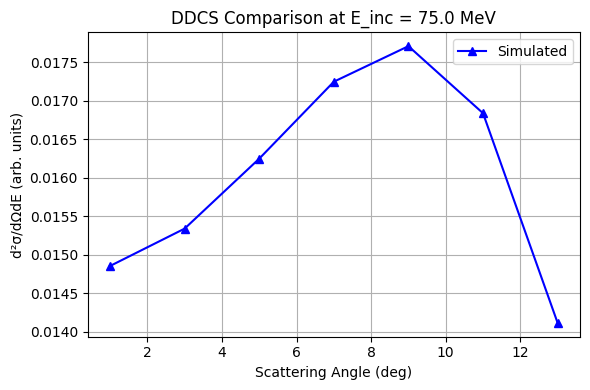

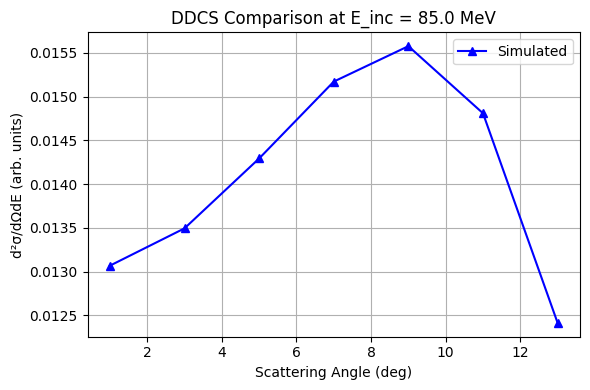

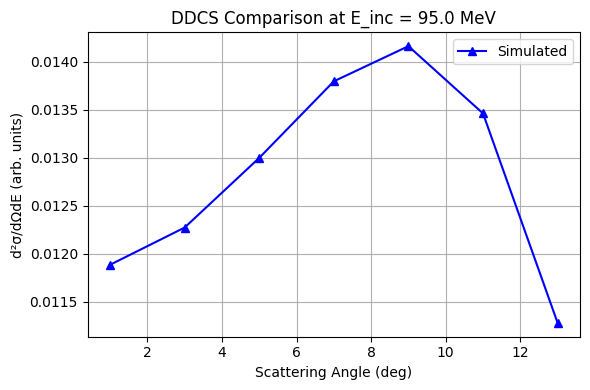

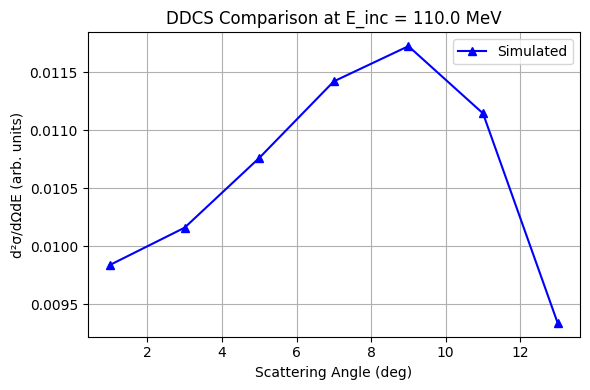

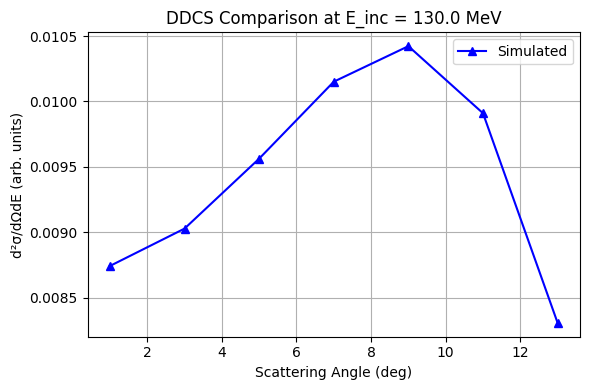

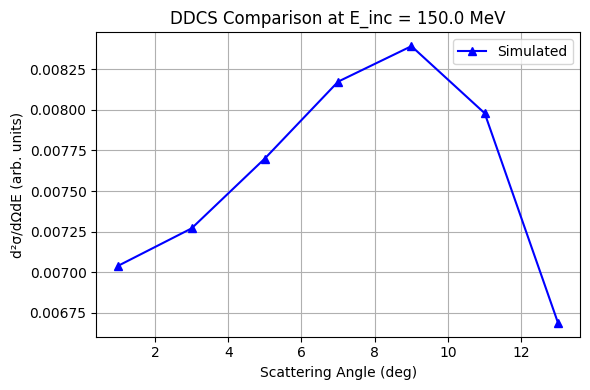

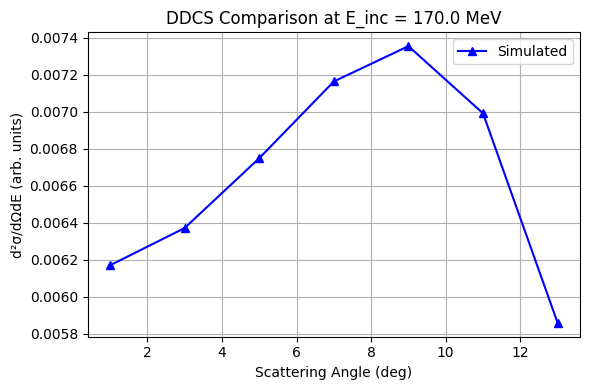

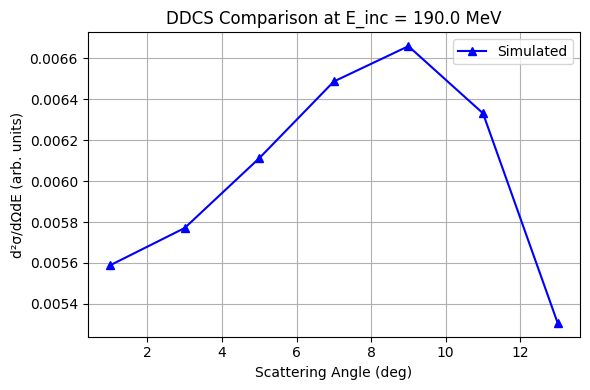

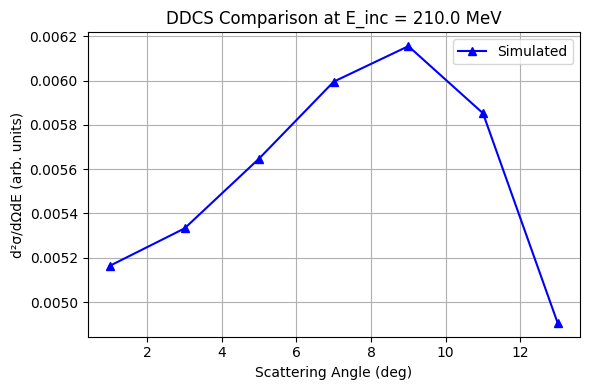

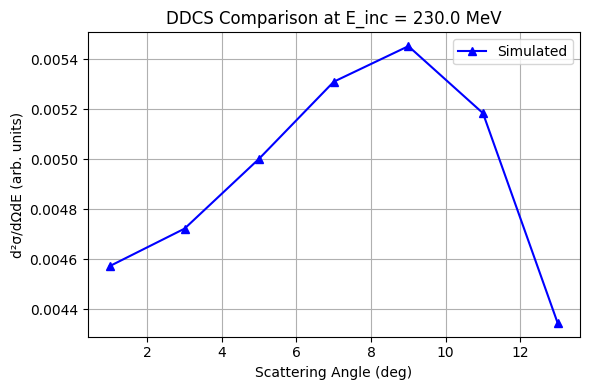


Evaluation Summary:
 - E_inc = 65.0 MeV | KL divergence = 0.004608
 - E_inc = 75.0 MeV | KL divergence = 0.004867
 - E_inc = 85.0 MeV | KL divergence = 0.003798
 - E_inc = 95.0 MeV | KL divergence = 0.002371
 - E_inc = 110.0 MeV | KL divergence = 0.001575
 - E_inc = 130.0 MeV | KL divergence = 0.000967
 - E_inc = 150.0 MeV | KL divergence = 0.000619
 - E_inc = 170.0 MeV | KL divergence = 0.000666
 - E_inc = 190.0 MeV | KL divergence = 0.000647
 - E_inc = 210.0 MeV | KL divergence = 0.001119
 - E_inc = 230.0 MeV | KL divergence = 0.000980

Average KL Divergence: 0.002020


In [19]:
evaluate_model_against_ddcs(
    net,
    ddcs_pipeline=DDCSPipeline,  # or lambda wrapper if needed
    E_inc_unique=E_inc_unique,
    experimental_ddcs=experimental_ddcs,
    theta_exp_deg=[1, 3, 5, 7, 9, 11, 13],
    batch_size=2000,
    device=device
)